In [3]:
# === Bitcoin Daily Feature Factory (2014 → today) ===
# - Robust timestamp handling (no KeyError)
# - yfinance download
# - Wide technical/statistical features
# - Saves CSV & Parquet

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

# ---------------- Download & timestamp fix ----------------
print(" Downloading BTC-USD (daily) from Yahoo Finance...")
btc = yf.download(
    "BTC-USD",
    start="2014-01-01",
    interval="1d",
    auto_adjust=False,   # avoid FutureWarning changes in defaults
    progress=False
)

# Flatten any MultiIndex columns (some yfinance versions return tuples)
btc.columns = [c[0] if isinstance(c, tuple) else c for c in btc.columns]
btc = btc.rename(columns=str.lower)

# If the date is the index, move it to a normal column named 'timestamp'
if "date" not in btc.columns and "timestamp" not in btc.columns:
    btc = btc.reset_index().rename(columns={"Date": "timestamp", "date": "timestamp"})
else:
    btc = btc.rename(columns={"date": "timestamp"})

# Ensure timestamp is datetime and sorted
btc["timestamp"] = pd.to_datetime(btc["timestamp"], errors="coerce")
btc = btc.sort_values("timestamp").dropna(subset=["timestamp"]).reset_index(drop=True)

# Some Yahoo crypto frames have both 'close' and 'adj close'; we use 'close' by default
if "close" not in btc.columns and "adj close" in btc.columns:
    btc["close"] = btc["adj close"]

required = ["open","high","low","close","volume"]
missing = [c for c in required if c not in btc.columns]
if missing:
    raise ValueError(f"Missing columns after download: {missing}")

print(f" Data loaded: {len(btc)} rows from {btc['timestamp'].min().date()} to {btc['timestamp'].max().date()}")

# ---------------- Feature helpers ----------------
def ema(s, span): return s.ewm(span=span, adjust=False, min_periods=span).mean()

def wma(s, n):
    if n <= 1: return s
    w = np.arange(1, n+1)
    return s.rolling(n).apply(lambda x: np.dot(x, w) / w.sum(), raw=True)

def rsi(s, n=14):
    d = s.diff()
    gain, loss = d.clip(lower=0), -d.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100/(1+rs))

def true_range(h,l,c):
    pc = c.shift(1)
    return pd.concat([h-l, (h-pc).abs(), (l-pc).abs()], axis=1).max(axis=1)

def atr(h,l,c,n=14): return true_range(h,l,c).ewm(alpha=1/n, min_periods=n, adjust=False).mean()

def macd(c, fast=12, slow=26, signal=9):
    line = ema(c, fast) - ema(c, slow)
    sig  = ema(line, signal)
    return line, sig, line - sig

def stochastic_rsi(c, n=14, k=3, d=3):
    r = rsi(c, n)
    lo, hi = r.rolling(n).min(), r.rolling(n).max()
    stoch = (r - lo) / (hi - lo)
    kline = stoch.rolling(k).mean()
    dline = kline.rolling(d).mean()
    return stoch*100, kline*100, dline*100

def bollinger(c, n=20, z=2.0):
    ma, sd = c.rolling(n).mean(), c.rolling(n).std(ddof=0)
    up, lo = ma + z*sd, ma - z*sd
    bw = (up - lo) / ma
    pctb = (c - lo) / (up - lo)
    return ma, up, lo, bw, pctb

def trix(c, n=14, sig=9):
    e1 = c.ewm(span=n, adjust=False).mean()
    e2 = e1.ewm(span=n, adjust=False).mean()
    e3 = e2.ewm(span=n, adjust=False).mean()
    line = e3.pct_change()*100
    return line, line.ewm(span=sig, adjust=False).mean()

def obv(c, v):
    direction = np.sign(c.diff()).fillna(0)
    return (direction * v).fillna(0).cumsum()

def mfi(h,l,c,v, n=14):
    tp = (h + l + c) / 3
    mf = tp * v
    pmf = mf.where(tp > tp.shift(1), 0.0)
    nmf = mf.where(tp < tp.shift(1), 0.0)
    mfr = pmf.rolling(n).sum() / nmf.rolling(n).sum().replace(0, np.nan)
    return 100 - (100 / (1 + mfr))

def cci(h,l,c, n=20):
    tp = (h + l + c) / 3
    sma = tp.rolling(n).mean()
    mad = (tp - sma).abs().rolling(n).mean()
    return (tp - sma) / (0.015 * mad)

def dmi_adx(h,l,c, n=14):
    up, dn = h.diff(), -l.diff()
    plus_dm  = np.where((up > dn) & (up > 0), up, 0.0)
    minus_dm = np.where((dn > up) & (dn > 0), dn, 0.0)
    atr_v = atr(h,l,c,n)
    plus_di  = 100 * pd.Series(plus_dm, index=h.index).ewm(alpha=1/n, adjust=False).mean() / atr_v
    minus_di = 100 * pd.Series(minus_dm, index=h.index).ewm(alpha=1/n, adjust=False).mean() / atr_v
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan)) * 100
    adx = dx.ewm(alpha=1/n, adjust=False, min_periods=n).mean()
    return plus_di, minus_di, adx

# ---------------- Feature computation ----------------
def compute_features(df):
    df = df.copy()
    o,h,l,c,v = df["open"], df["high"], df["low"], df["close"], df["volume"]

    # returns & diffs
    df["ret_1"]   = c.pct_change()
    df["log_ret"] = np.log(c).diff()
    df["ret_5"]   = c.pct_change(5)
    df["ret_21"]  = c.pct_change(21)
    df["hl_range"]= h - l
    df["co_diff"] = c - o
    df["gap_cc"]  = c.diff()

    # trend (MA/EMA/WMA)
    for n in [7, 25, 99]:
        df[f"ma_{n}"] = c.rolling(n).mean()
    for n in [12, 26, 50]:
        df[f"ema_{n}"] = ema(c, n)
    df["wma_10"] = wma(c, 10)

    # Bollinger
    bb_ma, bb_up, bb_lo, bb_bw, bb_pb = bollinger(c, 20, 2.0)
    df["bb_ma_20"], df["bb_up_20"], df["bb_lo_20"], df["bb_bw_20"], df["bb_pctb_20"] = bb_ma, bb_up, bb_lo, bb_bw, bb_pb

    # Oscillators
    df["rsi_14"] = rsi(c, 14)
    st_rsi, k, d = stochastic_rsi(c, 14, 3, 3)
    df["stochrsi_14"], df["stochrsi_k"], df["stochrsi_d"] = st_rsi, k, d

    macd_line, macd_sig, macd_hist = macd(c, 12, 26, 9)
    df["macd"], df["macd_signal"], df["macd_hist"] = macd_line, macd_sig, macd_hist

    trix_line, trix_sig = trix(c, 14, 9)
    df["trix_14"], df["trix_signal"] = trix_line, trix_sig

    # volatility
    df["atr_14"] = atr(h, l, c, 14)
    df["vol_20_annual"] = df["log_ret"].rolling(20).std() * np.sqrt(252)

    # volume & flow
    df["obv"]    = obv(c, v)
    df["mfi_14"] = mfi(h, l, c, v, 14)
    df["vol_5_mean"]  = v.rolling(5).mean()
    df["vol_20_mean"] = v.rolling(20).mean()
    df["vol_z_20"]    = (v - df["vol_20_mean"]) / v.rolling(20).std(ddof=0)
    df["log_vol_chg"] = np.log(v.replace(0, np.nan)).diff()

    # CCI & DMI/ADX
    df["cci_20"] = cci(h, l, c, 20)
    plus_di, minus_di, adx = dmi_adx(h, l, c, 14)
    df["plus_di_14"], df["minus_di_14"], df["adx_14"] = plus_di, minus_di, adx

    # higher-order stats
    df["roll_skew_20"] = df["log_ret"].rolling(20).skew()
    df["roll_kurt_20"] = df["log_ret"].rolling(20).kurt()

    # composites
    df["typ_price"]    = (h + l + c) / 3.0
    df["median_price"] = (h + l) / 2.0
    df["ohlc4"]        = (o + h + l + c) / 4.0

    # remove initial NaNs from rolling windows
    return df.dropna().reset_index(drop=True)

btc_feat = compute_features(btc)
print(f"Features computed: {btc_feat.shape[1]} columns × {btc_feat.shape[0]} rows")

# ---------------- Save ----------------
btc_feat.to_csv("btc_features_daily.csv", index=False)
btc_feat.to_parquet("btc_features_daily.parquet")
print(" Saved files: btc_features_daily.csv  |  btc_features_daily.parquet")

# quick peek
btc_feat.tail(3)


ModuleNotFoundError: No module named 'yfinance'

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Example: does volume (X) Granger-cause returns (Y)?
df = btc_feat[['ret_1', 'volume']].dropna()
grangercausalitytests(df[['ret_1', 'volume']], maxlag=5)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7426  , p=0.3889  , df_denom=3952, df_num=1
ssr based chi2 test:   chi2=0.7432  , p=0.3886  , df=1
likelihood ratio test: chi2=0.7431  , p=0.3887  , df=1
parameter F test:         F=0.7426  , p=0.3889  , df_denom=3952, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4288  , p=0.6513  , df_denom=3949, df_num=2
ssr based chi2 test:   chi2=0.8586  , p=0.6510  , df=2
likelihood ratio test: chi2=0.8585  , p=0.6510  , df=2
parameter F test:         F=0.4288  , p=0.6513  , df_denom=3949, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3474  , p=0.7911  , df_denom=3946, df_num=3
ssr based chi2 test:   chi2=1.0440  , p=0.7906  , df=3
likelihood ratio test: chi2=1.0438  , p=0.7907  , df=3
parameter F test:         F=0.3473  , p=0.7911  , df_denom=3946, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3323  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(0.7426303876141483),
    np.float64(0.38887185604160557),
    np.float64(3952.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.7431941252565679),
    np.float64(0.3886396031764814),
    np.int64(1)),
   'lrtest': (np.float64(0.7431243062565045),
    np.float64(0.38866188587495365),
    np.int64(1)),
   'params_ftest': (np.float64(0.7426303876141277),
    np.float64(0.38887185604160557),
    np.float64(3952.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.42877055340447073),
    np.float64(0.6513396705262033),
    np.float64(3949.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.85862687675932),
    np.float64(0.6509558626507425),
    np.int64(2)),
   'lrtest': (np.float64(0.8585336631258542),
    np.float64(0.6509862023383468),
    np.int64(2)),
   'params_ftest': (np.float64(0.42883782568361817),
    np.float64(0.6512958644090378),
    np.float64(3949.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],

linear_regression
None


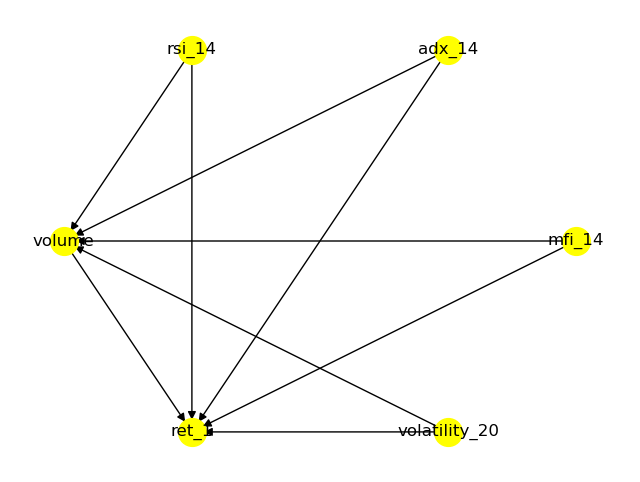

In [ ]:
import dowhy
from dowhy import CausalModel

model = CausalModel(
    data = btc_feat,
    treatment='volume',
    outcome='ret_1',
    common_causes=['volatility_20','mfi_14','adx_14','rsi_14']
)

model.view_model()
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate.value)


The DAG (Directed Acyclic Graph) visually represents the assumed causal relationships between variables:
    volume → ret_1 is the main causal path being tested — whether trading volume influences daily returns.
    volatility_20, mfi_14, adx_14, and rsi_14 are confounders — they affect both volume and ret_1.
        For example, higher volatility can increase trading activity (volume) and also impact returns.
        Momentum indicators like RSI or ADX can influence both market participation and price changes.
    The arrows show directional dependencies (who affects whom) without any loops — meaning no variable feeds back into itself.

In short, the DAG shows that market conditions (volatility, momentum, and trend) influence both volume and returns,
while the model isolates whether volume still has a direct effect on returns after controlling for those factors.

In [ ]:
import pandas as pd

sheets = pd.read_excel("indicatorsMY_v01.xlsx", sheet_name=None)

# Vérifie les noms des feuilles
print(sheets.keys())


dict_keys(['Alternatives', 'Market_Indicators', 'Price_Level_BTC', 'Open_Interests_Futures', 'Money_Supply', 'Central_Banks_Balance_Sheets', 'Central_Banks_Policy_Rates', 'TED_Spreads', '3M_Gov__Bonds', 'Yield_Curve', 'Foreign_Exchange', 'Miscellaneous', 'Gross_Domestic_Products', 'Industrial_Production', 'Retail_Sales', 'Inflation', 'Economic_Surprises', 'Economic Policy Uncertainty', 'Semiconductor_Market_Dynamics'])


In [ ]:
# Exemple : afficher les premières lignes de la feuille 'Alternatives'
df = sheets['Alternatives']
df.shape

(136, 5869)

In [ ]:
import pandas as pd

df_list = []

for name, sheet in sheets.items():
    #  Nettoyage de base
    sheet = sheet.dropna(how='all', axis=0)
    sheet = sheet.dropna(how='all', axis=1)
    
    #  Vérifier qu’il y a au moins 3 colonnes (sinon ignorer)
    if sheet.shape[1] < 3:
        continue
    
    #  Renommer les deux premières colonnes
    sheet.columns = ['Ticker', 'Variable'] + list(sheet.columns[2:])
    
    #  Transformer les dates en lignes (unpivot / melt)
    melted = sheet.melt(
        id_vars=['Ticker', 'Variable'],
        var_name='Date',
        value_name='Value'
    )
    
    #  Nettoyer les dates et valeurs
    melted['Date'] = pd.to_datetime(melted['Date'], errors='coerce')
    melted = melted.dropna(subset=['Date', 'Value'])
    
    #  Nettoyer les chaînes de texte (espaces, majuscules, etc.)
    melted['Ticker'] = melted['Ticker'].astype(str).str.strip()
    melted['Variable'] = melted['Variable'].astype(str).str.strip()
    
    #  Ajouter le nom de la feuille (pour traçabilité)
    melted['Category'] = name
    
    df_list.append(melted)

#  Fusion finale
merged_df = pd.concat(df_list, ignore_index=True)

#  Sauvegarde du dataset propre
merged_df.to_csv("clean_bitcoin_macro_dataset.csv", index=False)

print("Fusion terminée avec succès !")
print("Nombre total de lignes :", merged_df.shape[0])
print("Nombre total de colonnes :", merged_df.shape[1])
print("Exemple de données :")
print(merged_df.head(10))


C:\Users\marce\AppData\Local\Temp\ipykernel_18324\2392487910.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melted['Date'] = pd.to_datetime(melted['Date'], errors='coerce')


Fusion terminée avec succès !
Nombre total de lignes : 913909
Nombre total de colonnes : 5
Exemple de données :
       Ticker Variable       Date     Value      Category
0  DXY Curncy  px_open 2009-10-12  76.34801  Alternatives
1  DXY Curncy  px_last 2009-10-12  76.12601  Alternatives
2  DXY Curncy  px_high 2009-10-12  76.66801  Alternatives
3  DXY Curncy   px_low 2009-10-12    76.021  Alternatives
4  XAU Curncy  px_open 2009-10-12    1049.2  Alternatives
5  XAU Curncy  px_last 2009-10-12   1057.03  Alternatives
6  XAU Curncy  px_high 2009-10-12   1059.28  Alternatives
7  XAU Curncy   px_low 2009-10-12    1047.2  Alternatives
8   SPX Index  px_open 2009-10-12   1071.63  Alternatives
9   SPX Index  px_last 2009-10-12   1076.19  Alternatives


In [ ]:
# Voir toutes les catégories disponibles
print("Catégories disponibles :")
print(merged_df['Category'].unique())
print("\nNombre total de catégories :", merged_df['Category'].nunique())

# Voir tous les tickers disponibles
print("\nTickers disponibles :")
print(merged_df['Ticker'].unique())
print("\nNombre total de tickers :", merged_df['Ticker'].nunique())

# Voir toutes les variables disponibles (px_open, px_last, etc.)
print("\nVariables disponibles :")
print(merged_df['Variable'].unique())
print("\nNombre total de variables :", merged_df['Variable'].nunique())


Catégories disponibles :
['Alternatives' 'Market_Indicators' 'Price_Level_BTC'
 'Open_Interests_Futures' 'Money_Supply' 'Central_Banks_Balance_Sheets'
 'Central_Banks_Policy_Rates' 'TED_Spreads' '3M_Gov__Bonds' 'Yield_Curve'
 'Foreign_Exchange' 'Miscellaneous' 'Gross_Domestic_Products'
 'Industrial_Production' 'Retail_Sales' 'Inflation' 'Economic_Surprises'
 'Semiconductor_Market_Dynamics']

Nombre total de catégories : 18

Tickers disponibles :
['DXY Curncy' 'XAU Curncy' 'SPX Index' 'CCMP Index' 'RTY Index'
 'CRY Index' 'SPGSCITR Index' 'SXXP Index' 'SHCOMP Index' 'LUATTRUU Index'
 'LUACTRUU Index' 'LF98TRUU Index' 'NKY Index' 'XETUSD Curncy'
 'XLCUSD Curncy' 'XBNUSD Curncy' 'XRPUSD Curncy' 'XDGUSD Curncy'
 'XADUSD Curncy' 'XSOUSD Curncy' 'VIX Index' 'MOVE Index' 'CVIX Index'
 'nan' 'RIOT US Equity' 'MARA US Equity' 'JPMVXYGL Index' 'CIFR US Equity'
 'IREN US Equity' 'CORZ US Equity' 'XBTUSD Curncy' 'CFC5QOIN Index'
 'CFF5QOIN Index' 'CFC5QNCN Index' 'CFF5ROIN Index' 'CFF5RNCN Index'


In [ ]:
merged_df[['Category', 'Ticker', 'Variable']].drop_duplicates().head(50)

,Category,Ticker,Variable
0,Alternatives,DXY Curncy,px_open
1,Alternatives,DXY Curncy,px_last
2,Alternatives,DXY Curncy,px_high
3,Alternatives,DXY Curncy,px_low
4,Alternatives,XAU Curncy,px_open
5,Alternatives,XAU Curncy,px_last
6,Alternatives,XAU Curncy,px_high
7,Alternatives,XAU Curncy,px_low
8,Alternatives,SPX Index,px_open
9,Alternatives,SPX Index,px_last


In [ ]:
merged_df.shape

(913909, 5)

In [ ]:
merged_df.sample(20)

,Ticker,Variable,Date,Value,Category
722960,BDIY Index,px_open,2011-04-26,1250.0,Miscellaneous
3449,SXXP Index,px_high,2010-01-21,257.93,Alternatives
679427,JPYUSD Curncy,px_low,2016-07-03,0.009744,Foreign_Exchange
546362,GJGB3M Index,px_open,2012-03-06,0.106,3M_Gov__Bonds
24936,RTY Index,px_low,2011-10-14,698.81,Alternatives
190417,NKY Index,px_open,2022-05-11,26045.38,Alternatives
548886,GJGB3M Index,px_high,2012-11-08,0.105,3M_Gov__Bonds
26755,SPX Index,px_volume,2011-12-07,732674243.0,Alternatives
248508,XRPUSD Curncy,px_low,2024-08-04,0.5138,Alternatives
724977,IUTPELC Index,px_last,2011-09-01,103.59,Miscellaneous


In [ ]:
merged_df["Value"].dtype, merged_df["Value"].head()


(dtype('O'),
 0    76.34801
 1    76.12601
 2    76.66801
 3      76.021
 4      1049.2
 Name: Value, dtype: object)

In [ ]:
# Nettoyage global de la colonne Value
merged_df["Value"] = (
    merged_df["Value"]
    .astype(str)         # convertir en string
    .str.replace(",", ".")  # remplacer virgules
    .str.replace(" ", "")   # enlever espaces
    .str.replace("-", "")    # remplacer les tirets
)

# Conversion en float
merged_df["Value"] = pd.to_numeric(merged_df["Value"], errors="coerce")


In [ ]:
pivot_df = merged_df.pivot_table(
    index="Date",
    columns="Ticker",
    values="Value",
    aggfunc='mean'   # corrige les doublons mélangés
)


In [ ]:
corr = pivot_df.corr()
corr


Ticker,BASPTDSP Index,BDIY Index,BOJDPBAL Index,CCMP Index,CESICNY Index,CESIEUR Index,CESIJPY Index,CESIUSD Index,CFC5QNCN Index,CFC5QOIN Index,...,WGDPUS Index,XADUSD Curncy,XAU Curncy,XBNUSD Curncy,XBTUSD Curncy,XDGUSD Curncy,XETUSD Curncy,XLCUSD Curncy,XRPUSD Curncy,XSOUSD Curncy
Ticker,,,,,,,,,,,,,,,,,,,,,
BASPTDSP Index,1.000000,0.112017,0.304801,0.074222,-0.053814,0.031268,-0.157373,0.263389,0.250862,0.509872,...,0.052645,NaN,0.425114,0.155527,-0.093584,NaN,0.212377,0.112652,-0.012216,NaN
BDIY Index,0.112017,1.000000,0.050543,0.256508,-0.069542,0.080558,0.180371,-0.050104,0.184412,0.221020,...,0.858909,0.064751,0.151326,0.238371,0.285652,-0.030182,0.522776,0.468170,0.155017,-0.059235
BOJDPBAL Index,0.304801,0.050543,1.000000,0.479337,-0.108383,-0.147542,-0.140576,-0.152316,NaN,NaN,...,0.359531,0.466866,0.759721,0.089052,0.567184,0.404768,0.309741,0.024581,0.681880,0.330593
CCMP Index,0.074222,0.256508,0.479337,1.000000,0.052078,0.138508,0.013169,0.050675,-0.281469,-0.160226,...,0.658447,0.411718,0.692582,-0.088430,0.731843,0.384020,0.488304,0.100221,0.462725,0.364603
CESICNY Index,-0.053814,-0.069542,-0.108383,0.052078,1.000000,0.175646,0.173637,0.194962,0.170704,0.462412,...,0.312382,-0.344179,-0.021694,-0.085178,-0.062841,-0.312590,-0.162110,-0.050611,-0.216132,-0.078741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XDGUSD Curncy,NaN,-0.030182,0.404768,0.384020,-0.312590,-0.445710,0.006876,-0.351906,NaN,NaN,...,0.880650,0.895555,0.645556,0.740652,0.826001,1.000000,0.684444,0.701926,0.756862,0.826850
XETUSD Curncy,0.212377,0.522776,0.309741,0.488304,-0.162110,-0.229190,0.096438,-0.275997,0.810246,0.826600,...,0.694117,0.673763,0.674886,0.232232,0.828394,0.684444,1.000000,0.485001,0.615876,0.769069
XLCUSD Curncy,0.112652,0.468170,0.024581,0.100221,-0.050611,0.154544,0.395098,-0.129427,0.731006,0.767957,...,0.194709,0.744419,0.066803,0.695102,0.289245,0.701926,0.485001,1.000000,0.349267,0.704839


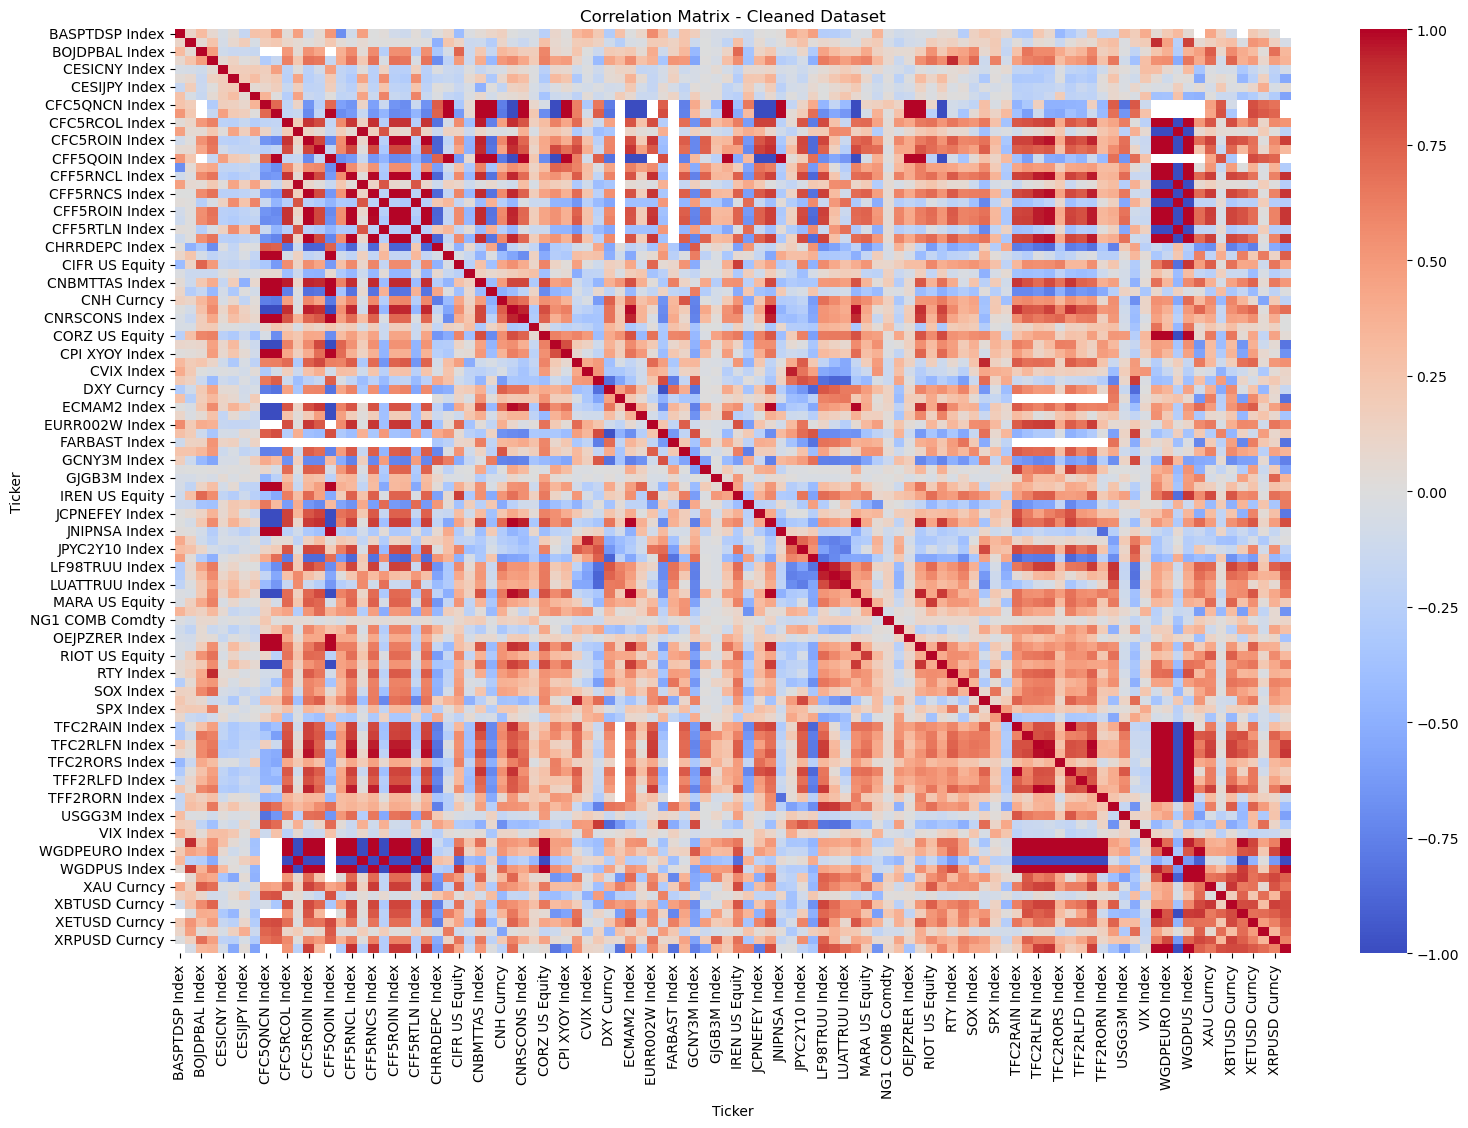

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - Cleaned Dataset")
plt.show()


In [ ]:
!pip install seaborn ipywidgets


In [ ]:
import ipywidgets as widgets
from IPython.display import display


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# 1 - Select only numeric columns
numeric_df = pivot_df.select_dtypes(include=['float64', 'int64'])

# 2 - Create a dropdown for selecting number of variables
var_selector = widgets.IntSlider(
    value=30,
    min=5,
    max=len(numeric_df.columns),
    step=1,
    description='Top N vars:',
    continuous_update=False
)

# 3 - Create a dropdown to choose the reference variable (BTC, etc.)
ref_selector = widgets.Dropdown(
    options=list(numeric_df.columns),
    value='XBTUSD Curncy' if 'XBTUSD Curncy' in numeric_df.columns else list(numeric_df.columns)[0],
    description='Reference:',
)

# 4 - Interactive plotting
def interactive_corr(reference, top_n):
    plt.figure(figsize=(12, 10))

    # Sort correlations by reference variable
    corr_sorted = numeric_df.corr()[reference].abs().sort_values(ascending=False)

    # Keep top N
    selected_vars = corr_sorted.index[:top_n]

    # Compute the selected correlation matrix
    corr_matrix = numeric_df[selected_vars].corr()

    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title(f"Correlation Matrix (Top {top_n} correlated with {reference})")
    plt.show()

# Launch interactive tool
interact(interactive_corr, reference=ref_selector, top_n=var_selector)


interactive(children=(Dropdown(description='Reference:', index=98, options=('BASPTDSP Index', 'BDIY Index', 'B…

<function __main__.interactive_corr(reference, top_n)>

In [ ]:
!pip install pytrends

In [ ]:
!pip install pandas requests lxml

In [ ]:
import time
from pytrends.request import TrendReq
import pandas as pd

# INITIALISATION SÉCURISÉE
pytrends = TrendReq(
    hl='en-US',
    tz=360,
    requests_args={'headers': {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}}
)

def get_google_trend(keyword, sleep_time=3):
    """
    Télécharge Google Trends pour UN mot-clé,
    avec retry + pause automatique.
    """
    print(f"\n🔍 Downloading Google Trends for: {keyword}")
    
    time.sleep(sleep_time)  # pause obligatoire pour éviter le 429

    try:
        pytrends.build_payload([keyword], timeframe='today 5-y')
        df = pytrends.interest_over_time()

        if df.empty:
            print("⚠️ Aucune donnée retournée (probable blocage).")
        else:
            print("✅ Données récupérées.")
        
        return df
    
    except Exception as e:
        print(f"❌ Erreur pour {keyword}: {e}")
        return None


In [ ]:
btc_trends = get_google_trend("Bitcoin")


🔍 Downloading Google Trends for: Bitcoin
❌ Erreur pour Bitcoin: The request failed: Google returned a response with code 429
